In [1]:
# ===============================================================
# SECTION 0 — START SPARK SESSION + IMPORTS
# ===============================================================

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder \
    .appName("CMS Big Data Outlier Detection") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "60") \
    .getOrCreate()

print("Spark session started.")




25/11/19 19:26:19 WARN Utils: Your hostname, Ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.3.15 instead (on interface enp0s8)
25/11/19 19:26:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 19:26:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark session started.


In [2]:

# ===============================================================
# SECTION 1 — LOAD CMS DATA
# ===============================================================

df = spark.read.csv(
    "file:///home/bigdata/Downloads/MUP_PHY_R25_P05_V20_D23_Prov.csv",
    header=True,
    inferSchema=True
)

print("Dataset loaded.")
df.printSchema()




Dataset loaded.
root
 |-- Rndrng_NPI: integer (nullable = true)
 |-- Rndrng_Prvdr_Last_Org_Name: string (nullable = true)
 |-- Rndrng_Prvdr_First_Name: string (nullable = true)
 |-- Rndrng_Prvdr_MI: string (nullable = true)
 |-- Rndrng_Prvdr_Crdntls: string (nullable = true)
 |-- Rndrng_Prvdr_Ent_Cd: string (nullable = true)
 |-- Rndrng_Prvdr_St1: string (nullable = true)
 |-- Rndrng_Prvdr_St2: string (nullable = true)
 |-- Rndrng_Prvdr_City: string (nullable = true)
 |-- Rndrng_Prvdr_State_Abrvtn: string (nullable = true)
 |-- Rndrng_Prvdr_State_FIPS: string (nullable = true)
 |-- Rndrng_Prvdr_Zip5: string (nullable = true)
 |-- Rndrng_Prvdr_RUCA: double (nullable = true)
 |-- Rndrng_Prvdr_RUCA_Desc: string (nullable = true)
 |-- Rndrng_Prvdr_Cntry: string (nullable = true)
 |-- Rndrng_Prvdr_Type: string (nullable = true)
 |-- Rndrng_Prvdr_Mdcr_Prtcptg_Ind: string (nullable = true)
 |-- Tot_HCPCS_Cds: integer (nullable = true)
 |-- Tot_Benes: integer (nullable = true)
 |-- Tot_Srvcs: 

In [3]:
# ===============================================================
# SECTION 2 — SELECT NUMERIC COLUMNS + NULL CLEANING
# ===============================================================

numeric_cols = [
    c.name for c in df.schema.fields
    if c.dataType in [DoubleType()] or "int" in str(c.dataType).lower()
]

# remove identifiers / geographic fields
remove_like = ["NPI", "Zip", "FIPS", "City", "State"]
numeric_cols = [c for c in numeric_cols if not any(x in c for x in remove_like)]

print("Numeric columns being used:")
print(numeric_cols)

# replace null with median for each numeric column
for c in numeric_cols:
    median_val = df.approxQuantile(c, [0.5], 0.01)[0]
    df = df.withColumn(c, F.when(F.col(c).isNull(), median_val).otherwise(F.col(c)))

print("Nulls replaced with medians.")



Numeric columns being used:
['Rndrng_Prvdr_RUCA', 'Tot_HCPCS_Cds', 'Tot_Benes', 'Tot_Srvcs', 'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Alowd_Amt', 'Tot_Mdcr_Pymt_Amt', 'Tot_Mdcr_Stdzd_Amt', 'Drug_Tot_HCPCS_Cds', 'Drug_Tot_Benes', 'Drug_Tot_Srvcs', 'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Alowd_Amt', 'Drug_Mdcr_Pymt_Amt', 'Drug_Mdcr_Stdzd_Amt', 'Med_Tot_HCPCS_Cds', 'Med_Tot_Benes', 'Med_Tot_Srvcs', 'Med_Sbmtd_Chrg', 'Med_Mdcr_Alowd_Amt', 'Med_Mdcr_Pymt_Amt', 'Med_Mdcr_Stdzd_Amt', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt', 'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt', 'Bene_Male_Cnt', 'Bene_Race_Wht_Cnt', 'Bene_Race_Black_Cnt', 'Bene_Race_API_Cnt', 'Bene_Race_Hspnc_Cnt', 'Bene_Race_NatInd_Cnt', 'Bene_Race_Othr_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt', 'Bene_CC_BH_ADHD_OthCD_V1_Pct', 'Bene_CC_BH_Alcohol_Drug_V1_Pct', 'Bene_CC_BH_Tobacco_V1_Pct', 'Bene_CC_BH_Alz_NonAlzdem_V2_Pct', 'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Bipolar_V1_Pct', 'Bene_CC_BH_Mood_V2_Pct', 'Bene_CC_BH_Depress_

Nulls replaced with medians.


In [4]:
# ===============================================================
# SECTION 3 — CREATE BILLING RATIO + SUBSET FOR OPTION B
# ===============================================================

key_cols = [
    "Tot_Sbmtd_Chrg",
    "Tot_Mdcr_Alowd_Amt",
    "Tot_Mdcr_Pymt_Amt",
    "Tot_Srvcs",
    "Drug_Tot_Srvcs",
    "Med_Tot_Srvcs",
    "Bene_Avg_Risk_Scre",
    "Bene_Avg_Age"
]

df_small = df.select(
    "Rndrng_Prvdr_Type",
    "Rndrng_Prvdr_State_Abrvtn",
    *key_cols
)

df_small = df_small.withColumn(
    "billing_ratio",
    F.col("Tot_Sbmtd_Chrg") / F.col("Tot_Mdcr_Alowd_Amt")
)

df_small = df_small.fillna(0)

print("Billing ratio created. Subset ready.")



Billing ratio created. Subset ready.


In [5]:
# ===============================================================
# SECTION 4 — PEER GROUP STATISTICS (STATE × SPECIALTY)
# ===============================================================

grouped_stats = df_small.groupBy(
    "Rndrng_Prvdr_Type", "Rndrng_Prvdr_State_Abrvtn"
).agg(
    F.mean("billing_ratio").alias("mean_ratio"),
    F.stddev("billing_ratio").alias("std_ratio"),
    F.expr("percentile_approx(billing_ratio, 0.25)").alias("q1_ratio"),
    F.expr("percentile_approx(billing_ratio, 0.75)").alias("q3_ratio")
)

df_joined = df_small.join(
    grouped_stats,
    on=["Rndrng_Prvdr_Type", "Rndrng_Prvdr_State_Abrvtn"],
    how="left"
).withColumn(
    "iqr_ratio",
    F.col("q3_ratio") - F.col("q1_ratio")
)

print("Peer statistics computed.")



Peer statistics computed.


In [6]:
# ===============================================================
# SECTION 5 — Z-SCORE OUTLIERS
# ===============================================================

df_joined = df_joined.withColumn(
    "z_score",
    (F.col("billing_ratio") - F.col("mean_ratio")) / F.col("std_ratio")
)

df_joined = df_joined.withColumn(
    "is_outlier_z",
    F.when(F.abs(F.col("z_score")) > 3, 1).otherwise(0)
)

print("Z-score outliers flagged.")



Z-score outliers flagged.


In [7]:
# ===============================================================
# SECTION 6 — IQR OUTLIERS
# ===============================================================

df_joined = df_joined.withColumn(
    "lower_iqr", F.col("q1_ratio") - 1.5 * F.col("iqr_ratio")
).withColumn(
    "upper_iqr", F.col("q3_ratio") + 1.5 * F.col("iqr_ratio")
)

df_joined = df_joined.withColumn(
    "is_outlier_iqr",
    F.when(
        (F.col("billing_ratio") < F.col("lower_iqr")) |
        (F.col("billing_ratio") > F.col("upper_iqr")),
        1
    ).otherwise(0)
)

print("IQR outliers flagged.")


IQR outliers flagged.


In [8]:
# ===============================================================
# SECTION 7 — KMEANS OUTLIERS
# ===============================================================

cluster_features = [
    "billing_ratio",
    "Drug_Tot_Srvcs",
    "Med_Tot_Srvcs",
    "Tot_Srvcs",
    "Bene_Avg_Risk_Scre",
    "Bene_Avg_Age"
]

assembler = VectorAssembler(
    inputCols=cluster_features,
    outputCol="features_raw"
)
df_k = assembler.transform(df_joined)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)
df_k_scaled = scaler.fit(df_k).transform(df_k)

kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(df_k_scaled)
df_km = model.transform(df_k_scaled)

centers = model.clusterCenters()

dist_udf = F.udf(
    lambda v, c: float(sum((v[i] - centers[c][i])**2 for i in range(len(v)))**0.5),
    "double"
)

df_km = df_km.withColumn(
    "kmeans_distance",
    dist_udf(F.col("features"), F.col("prediction"))
)

threshold = df_km.approxQuantile("kmeans_distance", [0.99], 0.01)[0]

df_km = df_km.withColumn(
    "is_outlier_kmeans",
    F.when(F.col("kmeans_distance") > threshold, 1).otherwise(0)
)

print("KMeans outliers flagged.")


25/11/19 19:28:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


KMeans outliers flagged.


In [9]:

# ===============================================================
# SECTION 8 — FINAL OUTLIER SUMMARY (FOR REPORT)
# ===============================================================

summary = df_km.select(
    F.sum("is_outlier_z").alias("Z_score_outliers"),
    F.sum("is_outlier_iqr").alias("IQR_outliers"),
    F.sum("is_outlier_kmeans").alias("KMeans_outliers")
)

summary.show()

print("PIPELINE COMPLETE.")



+----------------+------------+---------------+
|Z_score_outliers|IQR_outliers|KMeans_outliers|
+----------------+------------+---------------+
|           19521|       78184|              0|
+----------------+------------+---------------+

PIPELINE COMPLETE.


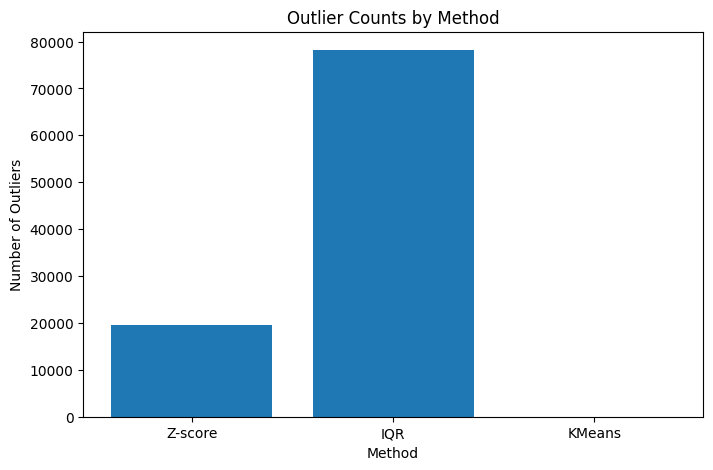

In [10]:
#Result Visualizations 
import matplotlib.pyplot as plt

methods = ["Z-score", "IQR", "KMeans"]
counts = [19521, 78184, 0]      # your real results

plt.figure(figsize=(8,5))
plt.bar(methods, counts)
plt.title("Outlier Counts by Method")
plt.xlabel("Method")
plt.ylabel("Number of Outliers")
plt.show()



In [16]:
# ===============================================================
# SECTION 9 — TOP 20 OUTLIERS (Z-score, IQR, KMeans)
# ===============================================================

# ---- TOP 20 Z-SCORE OUTLIERS ----
top20_z = df_km.filter(F.col("is_outlier_z") == 1) \
               .orderBy(F.abs(F.col("z_score")).desc()) \
               .limit(20)

print("TOP 20 Z-score outliers:")
top20_z.show(truncate=False)

# ---- TOP 20 IQR OUTLIERS ----
top20_iqr = df_km.filter(F.col("is_outlier_iqr") == 1) \
                 .orderBy(F.abs(F.col("billing_ratio") - F.col("q3_ratio")).desc()) \
                 .limit(20)

print("TOP 20 IQR outliers:")
top20_iqr.show(truncate=False)

# ---- TOP 20 KMEANS OUTLIERS ----
top20_kmeans = df_km.filter(F.col("is_outlier_kmeans") == 1) \
                    .orderBy(F.col("kmeans_distance").desc()) \
                    .limit(20)

print("TOP 20 KMeans outliers:")
top20_kmeans.show(truncate=False)




TOP 20 Z-score outliers:


+--------------------------------------+-------------------------+--------------+------------------+-----------------+---------+--------------+-------------+------------------+------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------+--------------------+------------------+--------------+------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+----------+------------------+-----------------+
|Rndrng_Prvdr_Type                     |Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|Tot_Mdcr_Pymt_Amt|Tot_Srvcs|Drug_Tot_Srvcs|Med_Tot_Srvcs|Bene_Avg_Risk_Scre|Bene_Avg_Age|billing_ratio     |mean_ratio        |std_ratio         |q1_ratio          |q3_ratio          |iqr_ratio          |z_score           |is_outlier_z|lower_iqr           |upper_iqr         |is_outli

+----------------------------------+-------------------------+--------------+------------------+-----------------+---------+--------------+-------------+------------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+------------------+--------------+------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+----------+------------------+-----------------+
|Rndrng_Prvdr_Type                 |Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|Tot_Mdcr_Pymt_Amt|Tot_Srvcs|Drug_Tot_Srvcs|Med_Tot_Srvcs|Bene_Avg_Risk_Scre|Bene_Avg_Age|billing_ratio     |mean_ratio        |std_ratio         |q1_ratio          |q3_ratio          |iqr_ratio         |z_score           |is_outlier_z|lower_iqr           |upper_iqr         |is_outlier_iqr|feat

+-----------------+-------------------------+--------------+------------------+-----------------+---------+--------------+-------------+------------------+------------+-------------+----------+---------+--------+--------+---------+-------+------------+---------+---------+--------------+------------+--------+----------+---------------+-----------------+
|Rndrng_Prvdr_Type|Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|Tot_Mdcr_Pymt_Amt|Tot_Srvcs|Drug_Tot_Srvcs|Med_Tot_Srvcs|Bene_Avg_Risk_Scre|Bene_Avg_Age|billing_ratio|mean_ratio|std_ratio|q1_ratio|q3_ratio|iqr_ratio|z_score|is_outlier_z|lower_iqr|upper_iqr|is_outlier_iqr|features_raw|features|prediction|kmeans_distance|is_outlier_kmeans|
+-----------------+-------------------------+--------------+------------------+-----------------+---------+--------------+-------------+------------------+------------+-------------+----------+---------+--------+--------+---------+-------+------------+---------+---------+--------------+---